In [1]:
import numpy as np
#There are 7 eeg files from one day for one animal
eeg = np.fromfile('JC283-eeg/20220909/JC283-20220909_01.eeg', dtype = np.uint16)
#eeg file, sampled at 1.25 kHz. Only includes data from the first channel of each tetrode
print(len(eeg))
print(eeg.shape)
print(eeg[:10])

#for 20220909 (training day 1) for JC283, session 1 and 2 refer to pre-sleep (sleep 1)
#The length of eeg 01 is 287997952, which is each of the 32 channels listed each after the other
#channels 17-32 are in the HPC, but 17 and 29 are grayed out (not used?)

tetrode_num = 18
#Taking tetrode 18, which is in the HPC
print(type(tetrode_num*len(eeg)/32))
one_channel = eeg[int(tetrode_num*len(eeg)/32) : int((tetrode_num+1)*len(eeg)/32)]; #Assuming that there are always 32 channels

287997952
(287997952,)
[   72   169   414   557 62623 62471 62586 61933 61537 61934]
<class 'float'>


Ripple detection GitHub from the Eden-Kramer lab: https://github.com/Eden-Kramer-Lab/ripple_detection
Karlsson et al. 2009; Kay et al. 2016
First it makes sense to bandpass filter the signal in the theta frequency (5-12 Hz)
Then find the significant events in this range (those with high power/amplitude)

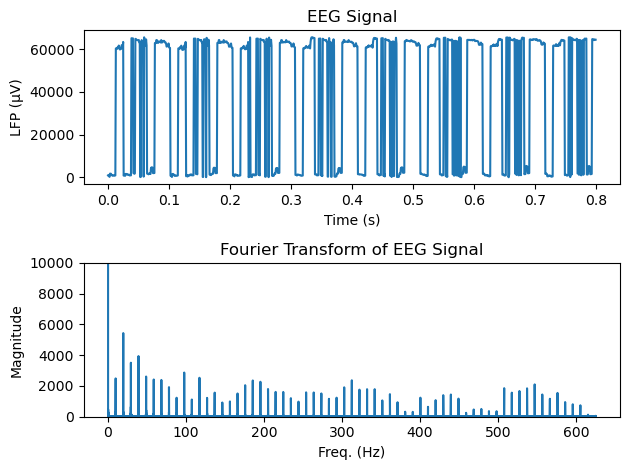

In [3]:
import matplotlib.pyplot as plt

#Showing the signal from only 1 sec, but taking the fft of the entire channel
subsample = one_channel[:1000]

# plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
fs = 1250  # 1.25 kHz, sampling freq
t = np.arange(len(subsample)) / fs  #Creating time axis
plt.plot(t, subsample)
plt.title('EEG Signal')
plt.xlabel('Time (s)')
plt.ylabel('LFP (μV)')

# Compute the Fourier Transform
n = len(one_channel)
yf = np.fft.fft(one_channel)
xf = np.fft.fftfreq(n, 1 / fs) #frequency bins of the fft

# Plot the Fourier Transform
plt.subplot(2, 1, 2)
plt.plot(xf[:n // 2], 2.0 / n * np.abs(yf[:n // 2]))
plt.title('Fourier Transform of EEG Signal')
plt.xlabel('Freq. (Hz)')
plt.ylabel('Magnitude')
# plt.xlim(2, 20)
plt.ylim(0, 10000)

plt.tight_layout()
plt.show()

In [42]:
# #From detector_utils in Vlad's github - but replacing frequency range of 150-250Hz with theta range
# #Nardin et al., 2005 uses a 3rd-order Butterworth filter to "extract theta signal (5-15 Hz)"
#     #They then linearly interpreted between local minima from 0 to 360 degrees

# from scipy.signal import sosfiltfilt, hilbert, remez, butter, sosfreqz, sos2tf
# def _get_ripplefilter_kernel(sampling_frequency):
#     """Returns a dynamically computed ripple filter kernel.
#     The kernel is 150-250 Hz bandpass with 40 db roll off and 10 Hz
#     sidebands. The sampling frequency is specified.
#     """
#     # Filter specifications
#     low_cutoff = 150  # Hz
#     high_cutoff = 250  # Hz
#     roll_off_db = 40  # dB ### roll off db per decade
#     sidebands_hz = 10  # Hz

#     # Calculate filter parameters
#     nyquist = 0.5 * sampling_frequency
#     low = (low_cutoff - sidebands_hz) / nyquist
#     high = (high_cutoff + sidebands_hz) / nyquist

#     # Design bandpass filter
#     sos = butter(N= roll_off_db/10, Wn=[low, high], btype='band', output='sos')
    
#     # # Frequency response of the filter
#     # frequencies, response = sosfreqz(sos, worN=8000, fs=sampling_frequency)

#     # # Optionally, you can plot the frequency response
#     # plt.plot(frequencies, 20 * np.log10(np.abs(response)))
#     # plt.title('Filter Frequency Response')
#     # plt.xlabel('Frequency (Hz)')
#     # plt.axvline(x=150)
#     # plt.axvline(x=250)
#     # plt.ylabel('Gain (dB)')
#     # plt.show()

#     # # Convert the second-order sections to a filter kernel
#     # filter_kernel = sos2tf(sos)[1]

#     return sos

# def filter_ripple_band(data, sampling_frequency = 1250):
#     """Returns a bandpass filtered signal w/ cutoffs, roll-off, and sidebands specified in _get_ripplefiter_kernel()

#     Parameters
#     ----------
#     data : array_like, shape (n_time,)

#     Returns
#     -------
#     filtered_data : array_like, shape (n_time,)

#     """
#     sos = _get_ripplefilter_kernel(sampling_frequency)
#     is_nan = np.any(np.isnan(data), axis=-1)
#     filtered_data = np.full_like(data, np.nan)
#     filtered_data[~is_nan] = sosfiltfilt( sos, data[~is_nan], axis=1 )
#     return filtered_data



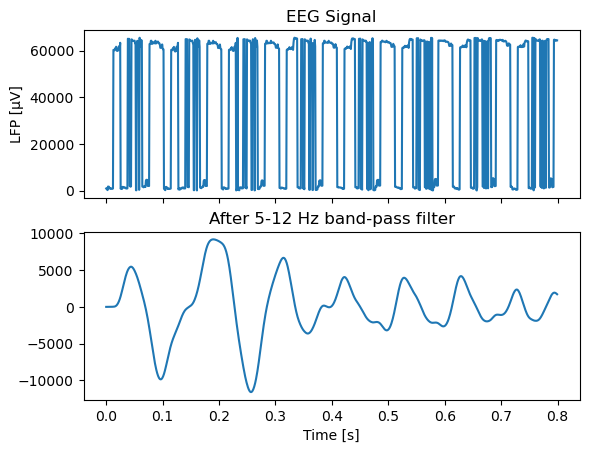

In [4]:
'''Use a Butterworth filter'''
#Butterworth filter for theta (5-12 Hz)
from scipy.signal import butter, freqs, sosfilt
# butter(N, Wn, btype='low', analog=False, output='ba', fs=None)
#     #where N is the order; Wn is the critical frequencies

'''Plot this filter's frequency response'''
# b,a = butter(N = 3, Wn = [5, 12], btype = 'bandpass', analog = False, output = 'sos', fs = 1250)
# b, a = butter(3, [5, 12], 'bandpass', analog = False, fs = 1250)  #output = 'sos',
# w, h = freqs(b, a)
# plt.semilogx(w, 20 * np.log10(abs(h)))
# plt.title('Butterworth filter frequency response')
# plt.xlabel('Frequency [radians / second]')
# plt.ylabel('Amplitude [dB]')
# plt.margins(0, 0.1)
# plt.grid(which='both', axis='both')
# plt.axvline(12, color='green') # cutoff frequency
# plt.axvline(5, color='green') # cutoff frequency
# plt.show()

'''Plot the signal and then the filtered signal'''
fig, axs = plt.subplots(2, 1, sharex = True)
axs[0].plot(t, subsample)
axs[0].set_ylabel('LFP [μV]')
axs[0].set_title('EEG Signal')

sos = butter(3, [5, 12], btype = 'bandpass', output = 'sos', analog = False, fs = 1250)
filtered = sosfilt(sos, subsample)
axs[1].plot(t, filtered)
axs[1].set_xlabel('Time [s]')
axs[1].set_title('After 5-12 Hz band-pass filter');

632.2763001778682
avg freq = 10.063794960913148 Hz


Text(0.5, 0, 'time [s]')

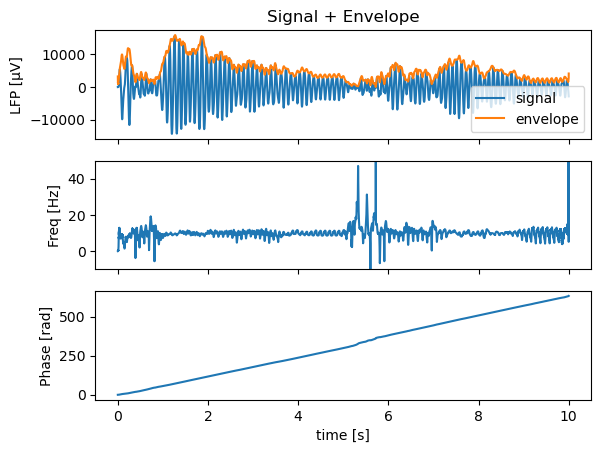

In [32]:
'''Using scipy.signal.hilbert'''
from scipy.signal import hilbert
import math
#Do this with a larger amt of data, ~10s
subsample = one_channel[:12500]
sos = butter(3, [5, 12], btype = 'bandpass', output = 'sos', analog = False, fs = 1250)
filtered = sosfilt(sos, subsample)

t = np.arange(len(subsample)) / fs  #Creating time axis


analytic_signal = hilbert(filtered) #Where filtered is a ~1s portion of the theta band-pass filtered EEG
amplitude_envelope = np.abs(analytic_signal)
inst_phase = np.unwrap(np.angle(analytic_signal))
inst_freq = (np.diff(inst_phase) / 
             (2.0 * np.pi) * fs)
fig, axs = plt.subplots(3, 1, sharex=True)
axs[0].plot(t, filtered, label = 'signal')
axs[0].set_title('Signal + Envelope')
axs[0].plot(t, amplitude_envelope, label = 'envelope')
axs[0].legend()
axs[0].set_ylabel('LFP [μV]')

axs[1].plot(t[1:], inst_freq, label = 'inst freq')
# axs[1].legend()
axs[1].set_ylim(-10, 50)
axs[1].set_ylabel('Freq [Hz]')
# #Graph a pure sine wave with freq = 8 Hz (middle of theta band) for reference
# def sine_func(x):
#     return 10000 * math.sin(8 * 2 * np.pi * x)
# vectorized_sine = np.vectorize(sine_func)
# y = vectorized_sine(t)
# axs[2].plot(t, y, label = 'sine wave')
# axs[2].set_title('8 Hz sine wave')

axs[2].plot(t, inst_phase)
axs[2].set_ylabel('Phase [rad]') #I think so
    #So avg freq of this bandpass filtered data would be phase(t = time) / time*2*pi
print(inst_phase[-1])
print('avg freq =', inst_phase[-1] / (t[-1] * 2 * np.pi), 'Hz')

axs[2].set_xlabel('time [s]')


#Am I supposed to be finding significant events in the theta band? 
    #So that would mean finding times when the envelope significantly deviates from its mean

In [ ]:
'''Determine time points at which there is a significant event'''

#Would it make sense to graph spikes (from the .clu/res files) as polar coordinates? Where r = time and theta = phase
#Import 